# Homework 1: Numpy, Scipy, Pandas

### Due Friday Sept 9, 2016 @ 9am


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="https://www.evernote.com/l/AUX8wzRzuFJMB53yGp1CR3ouUojjUvrR7FEB/image.png">

Name your repo something sensible (e.g. python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="https://www.evernote.com/l/AUV3Z6iVPuBN_Z6LUDZ6zBi-nmC3UQwer9gB/image.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
git clone https://github.com/profjsb/python-ay250-homework.git
cd /class/directories ## this will be different on your machine
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
```

e. To submit your work, send us (prof+GSIs) your github handle and repo name for us to clone (you'll need to add us to the repo if you've made a private one)

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="data/im2-1.png">

A tarball of the data is at: https://drive.google.com/open?id=0B4vIeCR-xYNnbXFJTTVlVnpUZkk

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint1: you'll need to figure out how to resize a numpy array
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [2]:
import numpy as np
from scipy import misc, signal, interpolate, ndimage
import matplotlib.pyplot as plt
% matplotlib inline

### read in the images
img_list = []
no_img = 100
for i in range(no_img):
    img = misc.imread('./Data/im2-'+str(i)+'.png')
    img_list.append(img[:,:,:3]) # ignore transparency channel
    
### resize each image
for i in range(no_img):
    im = img_list[i]
    im_gray = np.sum(im.astype('float'), axis=2)
    im_gray -= np.mean(im_gray)
    im_zoom = ndimage.interpolation.zoom(im_gray, (3.0,3.0)) # zoom in
    img_list[i] = im_zoom[200:700,:] # get rid of white bands
    
### time for some FFT
cor_list = []
im1 = img_list[0]
for i in range(no_img):
    im2 = img_list[i]
    corr = signal.fftconvolve(im1,im2[::-1,::-1],mode='same')
    cor_list.append(corr)
    
### finally, compute the offsets
offsets = []
x_cen, y_cen = np.unravel_index(np.argmax(cor_list[0]),cor_list[0].shape) # reference to first image
for i in range(no_img):
    x_max, y_max = np.unravel_index(np.argmax(cor_list[i]),cor_list[i].shape)
    # do a small area pixel weighted average
    side = 10
    small_area = cor_list[i][x_max-side:x_max+side+1,y_max-side:y_max+side+1]
    x_coll = np.sum(small_area, axis=1)
    x_inds = np.arange(x_max-side, x_max+side+1)
    x_avg = np.average(x_inds, weights = x_coll)
    y_coll = np.sum(small_area, axis=0)
    y_inds = np.arange(y_max-side, y_max+side+1)
    y_avg = np.average(y_inds, weights = y_coll)
    offset_x = (x_avg-x_cen) # offsets in x
    offset_y = (y_avg-y_cen) # offsets in y
    offsets.append((offset_x, offset_y))
    
for i in range(no_img):
    print("The offset of image {} is ({}, {}).".format(i, round(offsets[i][0],2), round(offsets[i][1],2)))

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [32]:
new_img_list = []
for i in range(no_img):
    new_img = ndimage.interpolation.shift(img_list[i],offsets[i])
    new_img_list.append(new_img)

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

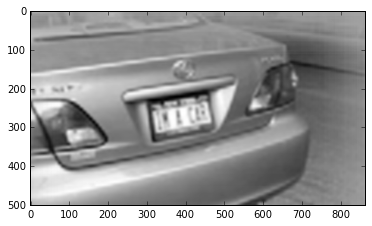

In [35]:
final_img = 0
for i in range(no_img):
    final_img += new_img_list[i]
    
final_img = final_img/no_img
plt.imshow(final_img, cmap=plt.get_cmap('gray'));

License plate says "IM A CAR" -- which is cute, but I wasted 2 days trying to figure out how to get this to work, sooooooooooo not cool!

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [5]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

Populating the interactive namespace from numpy and matplotlib


/Users/iene/anaconda/envs/ay250/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We define a simple utility function to listen to audio files right in the browser:

In [6]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [7]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `hw_0_data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [8]:
# your code here
signal = Audio('voice.wav')
signal

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [64]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    # your code here
    # FFT signal
    x_fft = np.fft.rfft(x)
    # sort this to get smallest components first
    sort_ind = np.argsort(x_fft)
    # drop fraction of the spectrum
    x_len = len(x_fft)
    x_drop = int(fraction * x_len)
    drop = sort_ind[:x_drop]
    x_fft[drop] = 0 # drop all of it
    # inverse FFT
    x_approx = np.fft.irfft(x_fft)
    return x_approx

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [65]:
x = np.random.rand(128)

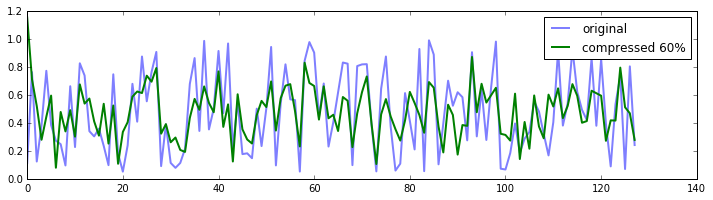

In [66]:
fraction = 0.6  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [41]:
def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    # your code here
    from scipy.io import wavfile
    # read input file
    rate, x = wavfile.read(fname)
    # do some compressing
    x_approx = compress_signal(x, fraction)
    # generate new file name
    new_fname = fname[:-4]+'_comp_'+str(fraction)+'.wav'
    wavfile.write(new_fname,rate,x_approx.astype(np.int16))
    # returns
    return rate, x, x_approx, new_fname

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](http://docs.python.org/2/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [67]:
# your code here
from collections import OrderedDict

ratio_list = [0.0,0.1,0.5,0.75,0.9,0.95,0.99]
voices = OrderedDict()
for ratio in ratio_list:
    rate, x, x_approx, new_fname = compress_wav('voice.wav',ratio)
    voices[ratio] = (x_approx, new_fname)

**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

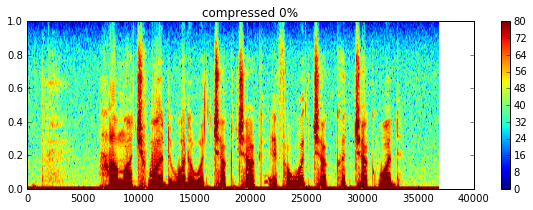

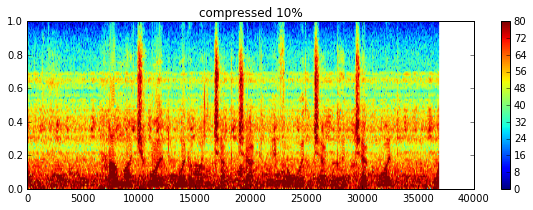

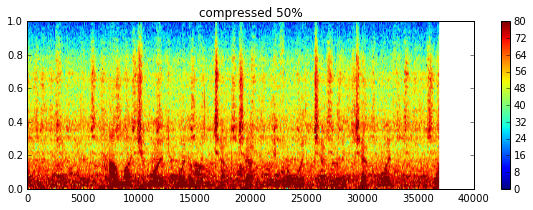

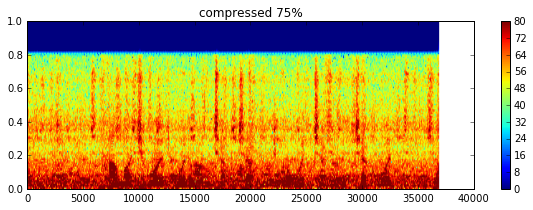

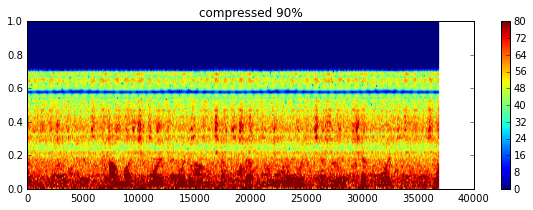

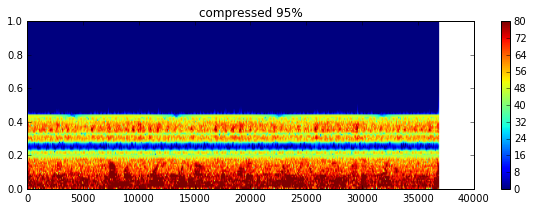

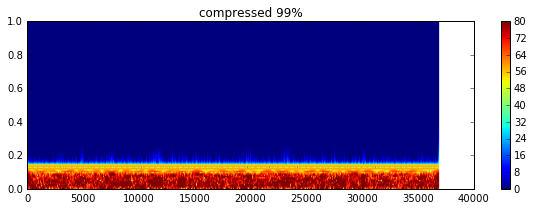

In [68]:
# your code here
for k,v in voices.items():
    # generate audio player
    Audio(v[1])
    # generate spectrogram
    specgram_cbar(v[0], title='compressed {0:.0%}'.format(k), clim=(0, 80) )

I can hear the recording up to (and including) ratio 0.95.

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle`

The period of the moon is 28 days.
One year has 367 days (give or take a couple).


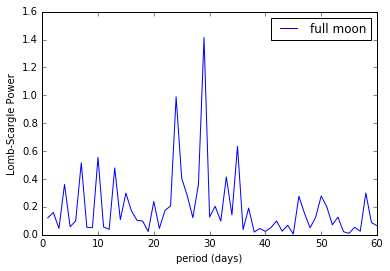

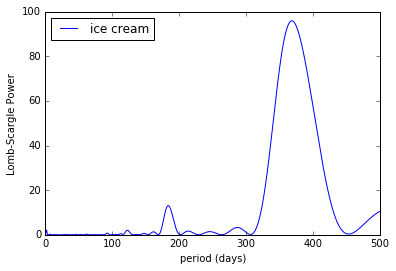

In [50]:
# your code here
import numpy as np
import pandas as pd
from scipy.signal.spectral import lombscargle

### read in data
data = pd.read_csv('merged_data.csv')

### change from weeks to day since start
data['Week'] = pd.to_datetime(data['Week'])    
data['time'] = (data['Week'] - data['Week'].min())  / np.timedelta64(1,'D')

# MOON
periods = np.linspace(1, 60, 60)
ang_freqs = 2 * np.pi / periods

# compute the (unnormalized) periodogram
power = lombscargle(data['time'].values,(data['full moon'].values-np.mean(data['full moon'].values))\
                    /np.std(data['full moon'].values), ang_freqs)

# normalize the power
N = len(data['time'].values)

# plot the results
fig, ax = plt.subplots()
#ax.plot(periods, np.sqrt(4*(power/N)))
ax.plot(periods, power, label='full moon')
ax.legend()
ax.set_xlabel('period (days)')
ax.set_ylabel('Lomb-Scargle Power')
moon = np.where(power == np.max(power))
print("The period of the moon is {} days.".format(moon[0][0]))

# DAYS IN YEAR
periods = np.linspace(1, 500, 500)
ang_freqs = 2 * np.pi / periods

# compute the (unnormalized) periodogram
power = lombscargle(data['time'].values,(data['ice cream'].values-np.mean(data['ice cream'].values))\
                    /np.std(data['ice cream'].values), ang_freqs)

# normalize the power
N = len(data['time'].values)

# plot the results
fig, ax = plt.subplots()
#ax.plot(periods, np.sqrt(4*(power/N)))
ax.plot(periods, power, label='ice cream')
ax.legend(loc=0)
ax.set_xlabel('period (days)')
ax.set_ylabel('Lomb-Scargle Power')
days_in_year = np.where(power == np.max(power))
print("One year has {} days (give or take a couple).".format(days_in_year[0][0]))

# #4: Reproducing some insights about the Election

Nate ("not a genius, just a Bayesian") Silver writes often about polls and their utility of predicting elections. One of the things he emphasized during the 2016 campaign is that even "large" polls of people with a consistent lead for one candidate will show wild swings in any given window in time.

**Problem 1**: Using Pandas and `numpy`, try to reproduce this plot from a Nate Silve Tweet qualitatively using the same assumptions.

<img src="https://www.evernote.com/l/AUU-KkH3Z-lBdKokzCzVIUe53YZLQ9e_AuMB/image.png">

https://twitter.com/NateSilver538/status/769565612955824128

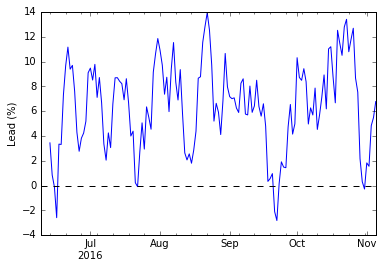

In [43]:
# your code here
### function to compute the 5-day rolling average lead (assuming only 2 candidates and people will choose one
### of the two candidates, i.e. they will not abstain or vote for somebody else)
def compute_lead(pt_lead, stddev, days, num_ppl):
    # percentage of votes needed to have a lead given by pt_lead
    lead_per = (50. + pt_lead/2.)/100. 
    # generate votes
    data = pd.Series(np.random.normal(loc=lead_per*num_ppl,scale=stddev,size=days), \
                 index=pd.date_range('6/9/2016', periods=days))
    # 5 day rolling average
    roll_avg = data.rolling(center=False,window=5).mean()
    roll_avg = roll_avg/num_ppl
    lead = (2 * roll_avg - 1) * 100
    return lead 

### generate some fake data
pt_lead = 6
stddev = 8 # assume a standard deviation of 10
days = 150 # 5-months period
num_ppl = 200. # people polled per day
lead = compute_lead(pt_lead, stddev, days, num_ppl)
lead.plot()
plt.axhline(0,color='k',ls='--')
plt.ylabel('Lead (%)');


**Problem 2**: Clearly, even with a 6% point lead, there's a chance that this sort of poll would show the other person in the lead. How much would ahead (in percent) would a candidate need to be to have a tracking poll never show the other candidate to be ahead over the course of a year (in your simulation)?

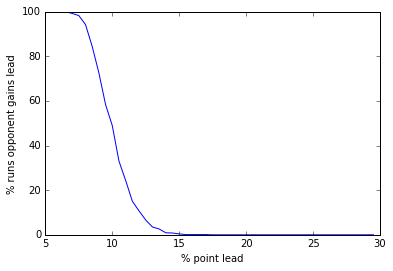

For a 200 people a day rolling 5-day poll, you need to have a 17.5% lead so that the result  always shows the leader ahead


In [44]:
# your code here
times_arr = []
pt_lead = np.arange(6, 30, 0.5)
stddev = 8
days = 365
num_ppl = 200.
for pt in pt_lead:
    times = 0
    for j in range(1000):
        lead = compute_lead(pt, stddev, days, num_ppl)
        if np.any(lead < 0):
            times +=1
    times_arr.append(times/10.)
    
plt.plot(pt_lead, times_arr)
plt.xlabel('% point lead')
plt.ylabel('% runs opponent gains lead')
plt.show()
first_lead = pt_lead[np.where(np.asarray(times_arr) == 0.0)[0][0]]
print("For a 200 people a day rolling 5-day poll, you need to have a {}% lead so that the result \
 always shows the leader ahead.".format(first_lead))

**Problem 3**: With a 3 and 6% lead, how many people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead (over a year)?

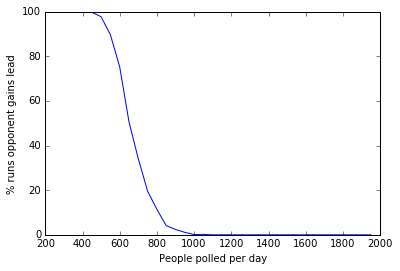

For a 3% lead, you need to poll at least 1100 people a day to have the rolling 5-day poll result always      show the leader ahead


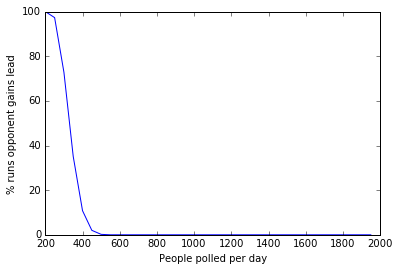

For a 6% lead, you need to poll at least 550 people a day to have the rolling 5-day poll result always      show the leader ahead


In [160]:
# your code here
for pt_lead in [3, 6]:
    times_arr = []
    stddev = 8
    days = 365
    num_ppl = range(200,2000,50)
    for ppl in num_ppl:
        times = 0
        for j in range(1000):
            lead = compute_lead(pt_lead, stddev, days, ppl)
            if np.any(lead < 0):
                times +=1
        times_arr.append(times/10.)

    plt.plot(num_ppl, times_arr)
    plt.xlabel('People polled per day')
    plt.ylabel('% runs opponent gains lead')
    plt.show()
    first_num = num_ppl[np.where(np.asarray(times_arr) == 0.0)[0][0]]
    print("For a {}% lead, you need to poll at least {} people a day to have the rolling 5-day poll result\
    always shows the leader ahead.".format(pt_lead, first_num))